# General imports

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

%matplotlib inline
import cv2

In [3]:
COLOR = '#62d197'

# Data

In [4]:
# Path to images folder
path = '../../data/Flipkart/Images/'

In [5]:
# charge from pickle file
data = pd.read_pickle('../../data/cleaned_df.pkl')

images_df = data[['image', 'main_category', 'category_code']].copy()
images_df.head()

image    main_category  category_code
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing              6
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care              5
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care              5
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing              6
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing              6

In [25]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          1050 non-null   object
 1   main_category  1050 non-null   object
 2   category_code  1050 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 24.7+ KB


In [26]:
images_df.groupby('main_category').count().reset_index()

main_category  image  category_code
0                   Baby Care    150            150
1    Beauty and Personal Care    150            150
2                   Computers    150            150
3  Home Decor & Festive Needs    150            150
4             Home Furnishing    150            150
5            Kitchen & Dining    150            150
6                     Watches    150            150

In [16]:
classes = list(images_df['category_code'].unique())
classes

[6, 5, 3, 2, 4, 1, 0]

Category: Home Furnishing


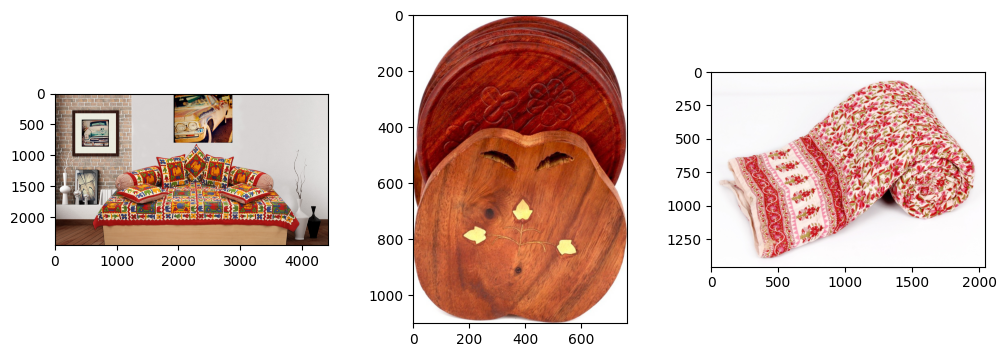

Category: Baby Care


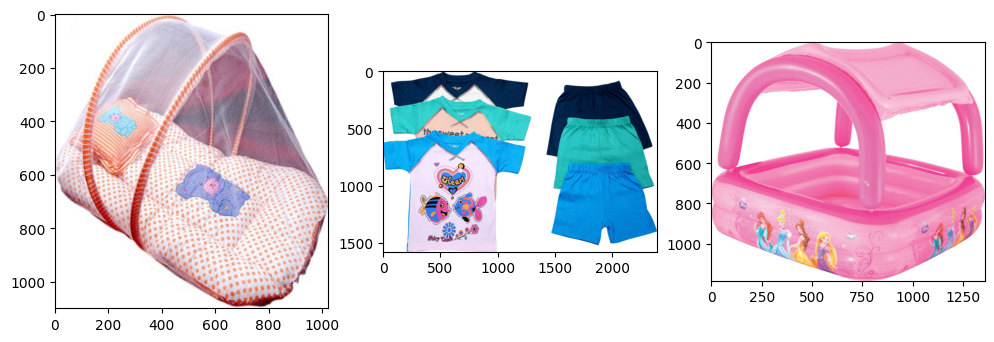

Category: Watches


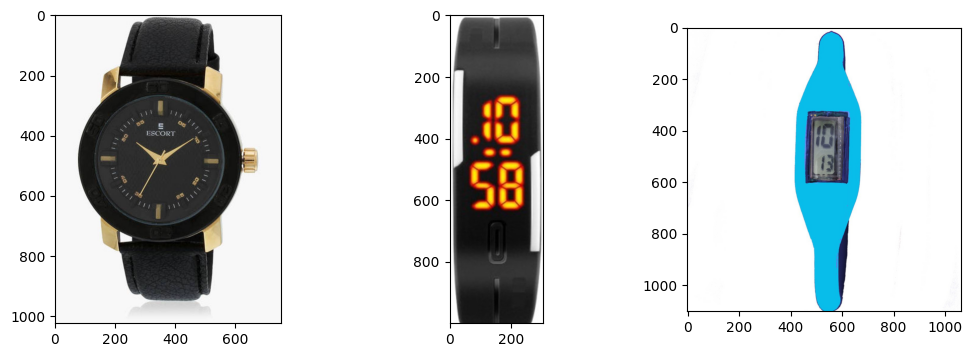

Category: Home Decor & Festive Needs


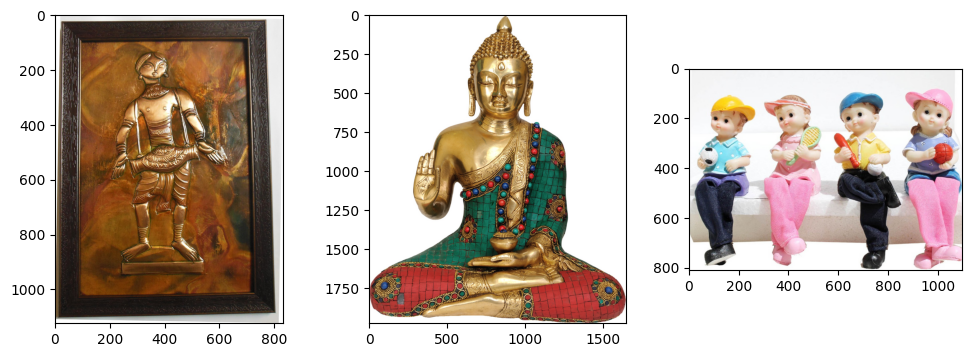

Category: Kitchen & Dining


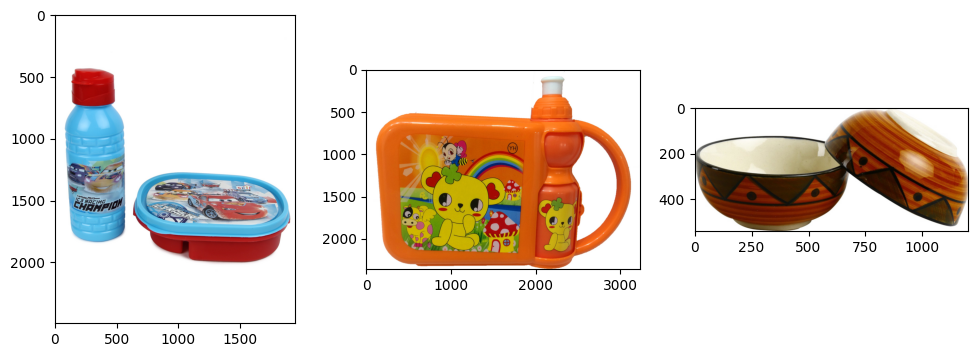

Category: Beauty and Personal Care


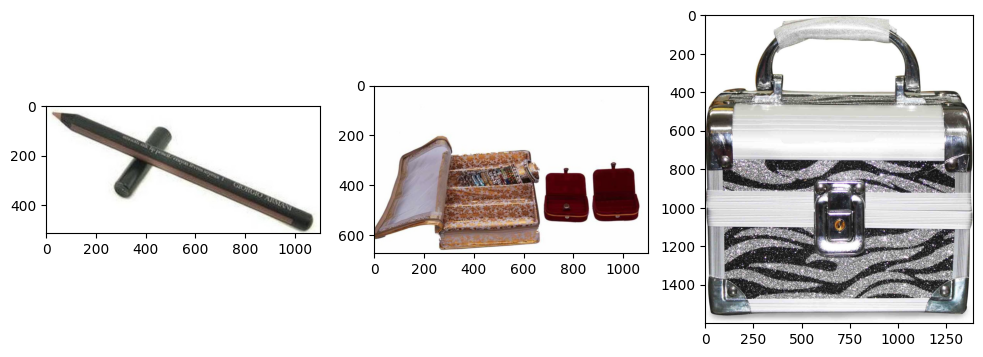

Category: Computers


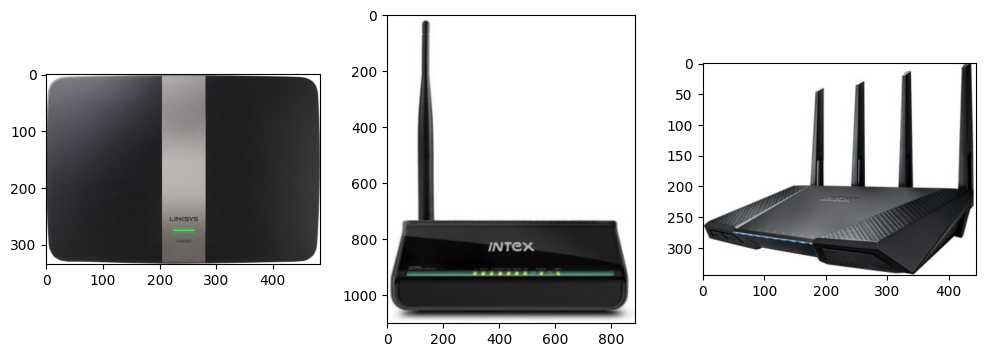

In [60]:
def list_fct(name):
    list_img = images_df['image'].tolist()
    list_image_name = [list_img[i] for i in range(len(images_df)) if images_df['main_category'][i] == name]
    return list_image_name

# Display 3 images for each category
for category in classes:
    print(f'Category: {category}')
    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        filename = path + list_fct(category)[i+10]
        image = imread(filename)
        plt.imshow(image)

    plt.show()

# EDA

### Functions

In [30]:
def list_fct(category:str, image: str, path:str=path):
    list_image_name = [path + image[i] for i in range(len(images_df)) if images_df['main_category'][i] == category]
    return list_image_name

def extract_img_features(image, flag: object = cv2.IMREAD_COLOR, images_path: str = path) -> pd.DataFrame:
    """Extract image features from a list of images.

    Args:
        image (str): the name of the image
        flag (object): the flag to read the images (default: cv2.IMREAD_COLOR)
        images_path (str): the path to the images (default: path)
    Returns:
        m
    """
    try:
        image = cv2.imread(images_path + image, flag) # returns an array [height, width, channels]
        return image.shape[0], image.shape[1], image.shape[2], image.size
    except Exception as e:
        print(f'Error reading image: {image}')
        print(f'Error: {e}')
        return  None * 4

## Images features

In [34]:
images_df['height'], images_df['width'], images_df['channels'], images_df['size'] = zip(*images_df['image'].map(extract_img_features))

In [35]:
images_df.loc[images_df['image'] == '9743e6d1c9f3180483825fe4d2e97836.jpg']

image main_category  category_code  \
343  9743e6d1c9f3180483825fe4d2e97836.jpg     Computers              0   

     height  width  channels    size  
343     541    534         3  866682

In [36]:
images_df.describe()

category_code        height        width  channels          size
count    1050.000000   1050.000000  1050.000000    1050.0  1.050000e+03
mean        3.000000   1220.038095  1196.570476       3.0  5.748901e+06
std         2.000953    744.841368   864.076765       0.0  1.175770e+07
min         0.000000    160.000000   145.000000       3.0  1.740000e+05
25%         1.000000    844.000000   747.250000       3.0  2.017125e+06
50%         3.000000   1100.000000  1100.000000       3.0  3.047550e+06
75%         5.000000   1360.000000  1214.250000       3.0  4.661820e+06
max         6.000000  11042.000000  8484.000000       3.0  2.810410e+08

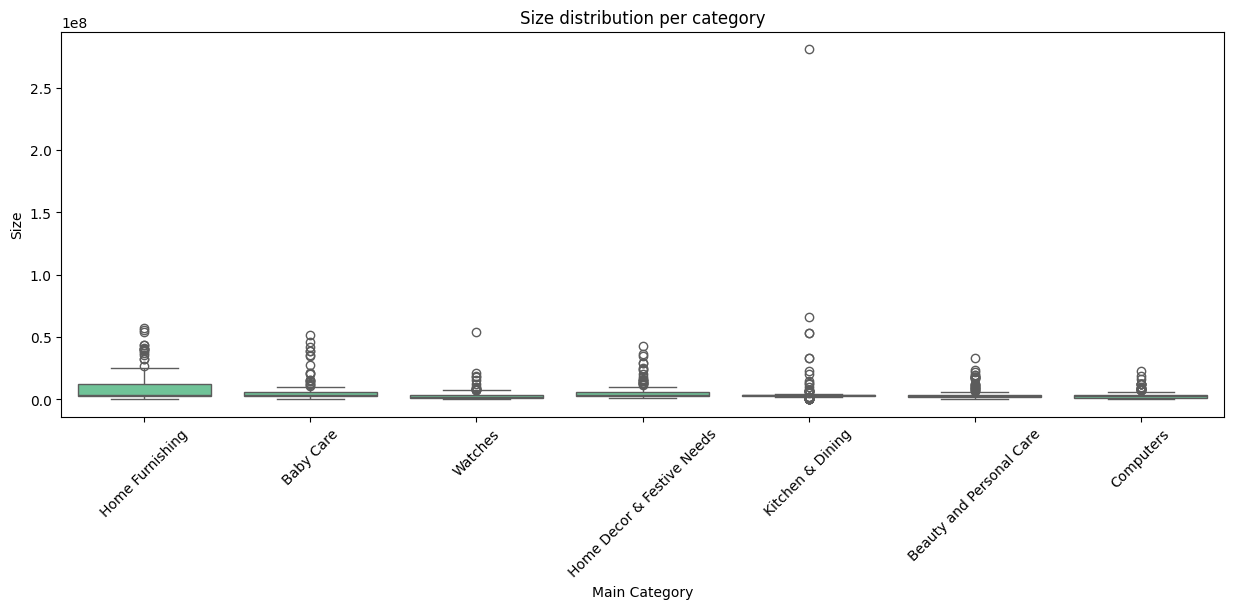

In [37]:
# Display stats per categories
plt.figure(figsize=(15, 5))
sns.boxplot(x='main_category', y='size', data=images_df, color=COLOR)
plt.title('Size distribution per category')
plt.xlabel('Main Category')
plt.ylabel('Size')
plt.xticks(rotation=45)
plt.show()

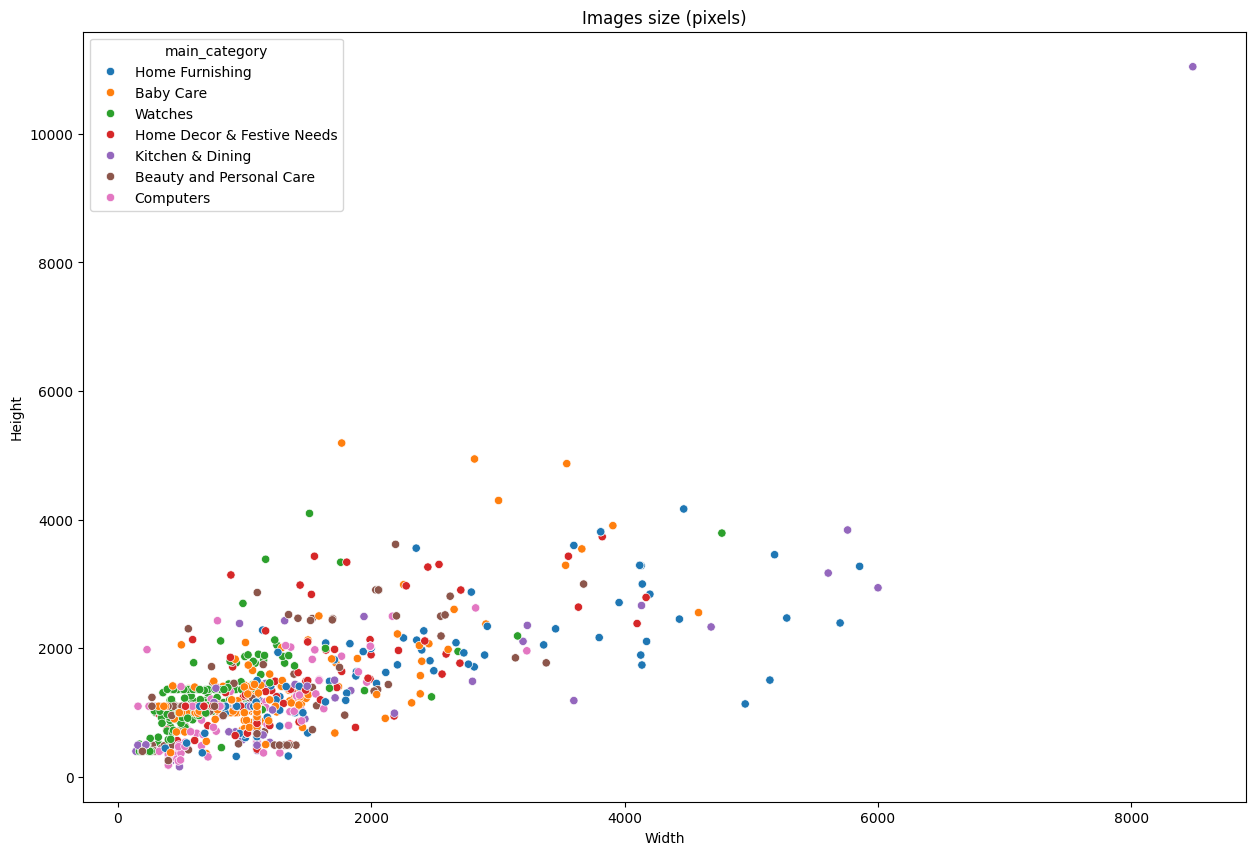

In [38]:
# Scatter plot of the witgh and length of the images
plt.figure(figsize=(15, 10))
sns.scatterplot(x='width', y='height', data=images_df, color=COLOR, hue='main_category')
plt.title('Images size (pixels)')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

Pictures are all in colors with high definition (mean of 1200 pixels). We observe an outlier for the category Kitchen and dining.

## Display few images

In [63]:
classes

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

# Features extraction

In [29]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import manifold, cluster
from collections import Counter

## Functions

### Images transformation

In [40]:
def resize_img(image: str, max_size: int, greyscale: bool=False) -> object:
    """Resize an image to a specific width and height. Change the image scale if needed.

    Args:
        image (str): the name of the image
        width (int): the width of the image (default: 300)
        height (int): the height of the image (default: 300)
        greyscale (bool): convert the image to greyscale (default: False)
    Returns:
        image (array): the resized image
    """
    # Calculate a resizing ratio to keep the original image aspect ratio
    ratio = max_size / max(image.shape[0], image.shape[1])
    width = int(image.shape[0] * ratio)
    height = int(image.shape[1] * ratio)
    try:
        print(f'Width: {width}, Height: {height}')
        image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

        if greyscale:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Clean created variables
        del(ratio, height, width)

        return image
    except Exception as e:
        print(f'Error resizing image: {image}')
        print(f'Error: {e}')
        return None

In [41]:
def extract_features(image: str) -> tuple:
    """Extract features from an image.

    Args:
        image (string): the image
    Returns:
        tupe: the set of keypoints and descriptors
    """
    try:
        # Instantiate the SIFT object
        sift = cv2.SIFT_create()
        # Equalize the histogram of the image
        # image = cv2.equalizeHist(image)
        # Detect and compute the descriptors
        keypoints , descriptors = sift.detectAndCompute(image, None)
    except Exception as e:
        print(f'Error reading image: {image}')
        print(f'Error: {e}')
    return keypoints, descriptors


In [42]:
def read_and_modify_image(image_path: str, resize: int=None, greyscale: bool=False) -> np.array:
    """Reads an image and modifies it if needed.

    Args:
        image_path (str): the path to the image
        resize (int, optional): the max height or width of the image. Defaults to None.
        greyscale (bool, optional): If change image to greyscale. Defaults to False.

    Returns:
        np.array: Image informations
    """
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Resize the image
    if resize:
        image = resize_img(image, resize)
    # Convert the image to greyscale
    if greyscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [ ]:
def get_descriptors(
    data: pd.DataFrame= images_df,
    path: str=path,
    resize: int=None,
    greyscale: bool=False
    ) -> list:
    """Save all the descriptors and display one result per category.

    Args:
        data (pd.DataFrame): the dataframe containing the images (default: images_df)
        path (str): the path to the images (default: path)
        resize (int): limit the size of width or height in pixels (default: None)
        greyscale (bool): convert the image to greyscale (default: False)

    Returns:
        list: the list of all descriptors
    """
    start_time = time.time()
    images_descriptors = []
    images_labels = []

    for row in tqdm(data.itertuples()):
        # Keep image index
        i = row.Index
        # read and transform image
        image = read_and_modify_image(path + row.image, resize, greyscale)
        if greyscale:
            # equalize the histogram of the image
            # It is used to improve the contrast in the image
            # Enhance the intensity distribution of the image
            # Robust to lighting changes
            image = cv2.equalizeHist(image)
        _, descriptors = extract_features(image)

        if descriptors is not None:
            images_descriptors.append(descriptors)
            images_labels.append(row.category_code)
        else:
            # drop the image if no descriptors
            data.drop(i, inplace=True)
            print(f'Dropped image: {row.image}')
            continue


    descriptors_per_image = [descriptor for descriptor in images_descriptors if descriptor is not None]
    print(f'Time taken: {time.time() - start_time:.2f}s')

    return descriptors_per_image

In [44]:
def get_histogram(img_descriptors: list, model: MiniBatchKMeans, n_clusters: int) -> np.ndarray:
    """Extract the histogram of the descriptors.

    Args:
        descriptors (np.ndarray): the descriptors
        n_clusters (int): the number of clusters (default: 10)
    Returns:
        np.ndarray: the histogram of the descriptors
    """

    try:
        histogram = np.zeros(len(model.cluster_centers_))
        labels = model.predict(img_descriptors)
        descriptors_number = len(img_descriptors)
        if  descriptors_number == 0 : print('No descriptors for image')
        for label in labels:
            histogram[label] += 1 / descriptors_number
        return histogram
    except Exception as e:
        print('Error calculating histogram')
        print(f'Error: {e}')
        return None

In [45]:
def get_vbow_and_labels(X: np.array, k: int, all_descriptors: list):
    """Get the Visual Bag of Words

    Args:
        X (np.ndarray): the descriptors
        range_to_test (np.ndarray): the range of clusters to test
        categories (list): the list of descriptors

    Returns:
        np.ndarray: the visual bag of words
    """
    # Instantiate the KMeans object using minibatch to improve speed
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Create the visual bag of words
    visual_bag_of_words = []
    for desc in tqdm(all_descriptors):
        hist = get_histogram(desc, kmeans, k)
        visual_bag_of_words.append(hist)

    visual_bag_of_words = np.array(visual_bag_of_words)

    return visual_bag_of_words, labels

In [46]:
def clusters_range(X:np.array, categories: list=classes):
    """ Calculate the range of clusters to test

    Args:
        X (np.ndarray): desciptors

    Returns:
    """
    # Square root method (square root of the number of the number of descriptors)
    n_clusters_sqrt = int(np.sqrt(len(X)))

    # Multiply the number of classes method
    n_clusters_classes = len(categories) * 10

    range_to_test = np.linspace(n_clusters_classes, n_clusters_sqrt, 10).astype(int)

    print(f'Number of clusters to test: {len(range_to_test)}')

    return range_to_test

### Plot

In [47]:
def display_keypoints(resize: int=None, greyscale: bool=False):
    """Display keypoints and descriptors of few images for each category.

    Args:
        resize (int, optional): _description_. Defaults to None.
        greyscale (bool, optional): _description_. Defaults to False.
    """
    categories = []
    while len(categories) < len(classes):
        for row in images_df.itertuples():
            category = row.main_category
            if category not in categories:
                image = read_and_modify_image(path + row.image, resize, greyscale)

                keypoints, descriptors = extract_features(image)
                img_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
                plt.figure(figsize=(5, 5))

                # display image with keypoints
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
                plt.title(f'Category {category}')
                plt.axis('off')

                # display histogram
                plt.subplot(1, 2, 2)
                plt.hist(image.ravel(), 256, [0, 256])
                plt.title('Histogram')

                plt.tight_layout()
                plt.show()

                # Diplay number of keypoints and descriptors size
                print(f'Image: {row.image}')
                print(f'Number of keypoints: {len(keypoints)}')
                print(f"Descriptors size: {descriptors.shape if descriptors is not None else (0, 0)}")

                categories.append(category)

In [49]:
def plot_tsne(best_pca_vector, best_ari, best_labels, real_labels, results:pd.DataFrame):
    """Plot the t-SNE representation of the data.

    Args:
        best_pca_vector (np.ndarray): the best PCA vector
        best_ari (float): the best ARI score
        best_labels (np.ndarray): the best labels
        real_labels (np.ndarray):
        results (pd.DataFrame): the results of the t-SNE
    """
    print('Diplay the T-SNE plot for the best result...')

    tsne = manifold.TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    X_tsne = tsne.fit_transform(best_pca_vector)
    print(f'ARI: {best_ari:.2f}, Vector dimension: {best_pca_vector.shape[1]}')
    fig = plt.figure(figsize=(13, 5), tight_layout=True)

    new_row = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    new_row['class'] = real_labels
    results = results.concat(new_row)


    ax = fig.add_subplot(1, 2, 1)
    scatter = ax.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=real_labels, cmap='tab10')
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=list(real_labels.unique()),
        title='Categories'
    )
    ax.set_title('Real labels')

    ax = fig.add_subplot(1, 2, 2)
    scatter = ax.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=best_labels, cmap='tab10')
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(best_labels),
        title='Clusters'
        )
    ax.set_title('Predicted labels')

    plt.show()

In [50]:
def compare_and_get_best_clusters(
    descriptors: list,
    real_labels: np.array,
    classes: list=classes
    ):
    """Plot and compare the 2D representation of the data.

    Args:
        descriptors (list): the list of descriptors
        real_labels (np.array): the real labels for each image
        classes (list): the classes

    Returns:
        np.array: the best pca vector
        np.array: the best labels
    """
    all_descriptors = np.vstack(descriptors)
    print(f'All descriptors shape: {all_descriptors.shape}')

    k_range = clusters_range(all_descriptors)
    print(f'Full resolution clusters range: {k_range}')

    ari_scores = []
    best_pca_vector = None
    best_labels = None
    best_ari = -1
    i = 1

    for k in k_range:
        print(f"Test {i} - Creating {k} descriptors clusters...")
        start_time = time.time()
        visual_bag_of_words, _ = get_vbow_and_labels(all_descriptors, k, descriptors)
        print(f'Visual bag of words dimension: {visual_bag_of_words.shape}')

        print('Starting dimensionality reduction...')
        pca = PCA(n_components=0.99, random_state=42)
        reduced_bow = pca.fit_transform(visual_bag_of_words)
        print(f'Reduced visual bag of words dimension: {reduced_bow.shape}')

        kmeans = KMeans(n_clusters=len(classes), random_state=42)
        kmeans.fit(reduced_bow)

        # Get ari score
        ari = adjusted_rand_score(real_labels, kmeans.labels_)
        ari_scores.append((reduced_bow.shape[1], ari))

        # Get best ari score
        if ari > best_ari:
            best_ari = ari
            best_pca_vector = reduced_bow
            best_labels = kmeans.labels_

        i += 1
        print(f'Time taken: {time.time() - start_time:.2f}s')

    print('scores:')
    print(sorted(ari_scores, key=lambda x: x[1], reverse=True))

    return best_ari, best_pca_vector, best_labels


## SIFT & Visual Bag of Words

Interesting source on [youtube](https://www.youtube.com/watch?v=4AvTMVD9ig0)

Scale-Invariant Feature Transform is a way for describing a local area in an image through a **feature vector**.

The goal is to reduce an image content into a set of locally distinct points called **descriptors**, that we will try to find in other images.

When a keypoint is found, we look in its neighborhood for intensity changes, gradient changes value of this area in order to describe it into a descriptor vector. So the descriptor is the vector discribing the surrondings of that point.

When comparing several images with same keypoints, it is possible to compare descriptors and make data associations between those images.

The keypoints are found using a **difference of Gaussian approach** which consist to take an image and blur it using a Gaussian blur at different magnetude. Then we substract the images from each other. After stacking thoses differences, we try to spot extreme points ==> Keypoints. It is also possible to apply different scales to the image to find these extreme points.

After finding the keypoint, we need to compute the descriptor by looking the neighborhood of the KP by breaking it in small parts and compute the gradient of these small areas. Gradient of local area are then collected into histograms to visualize how often certain gradient occur, what is their magnitude.

Steps :
- Get the images features (keypoints and descriptors)
- Define a range of number of clusters of descriptors to test
- Dimensionality reduction
- Predict clusters on reduced dimensionality

In [162]:
results_comparison = pd.DataFrame(columns=['Algorithm', 'Method', 'ARI'])

In [ ]:
df_tsne = pd.DataFrame(columns=['Method', 'tsne1', 'tsne2', 'class'])

### Full resolution

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_6638/1168618370.py:27: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(image.ravel(), 256, [0, 256])


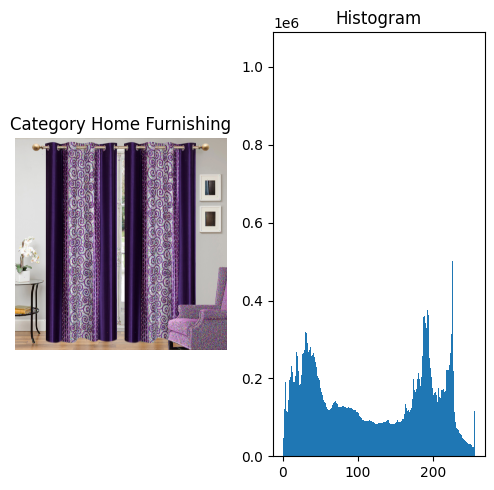

Image: 55b85ea15a1536d46b7190ad6fff8ce7.jpg
Number of keypoints: 93042
Descriptors size: (93042, 128)


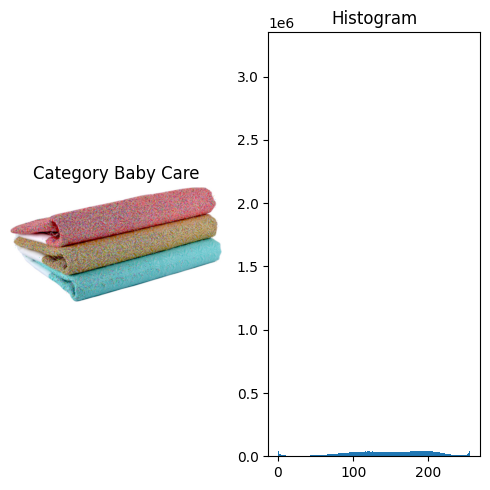

Image: 7b72c92c2f6c40268628ec5f14c6d590.jpg
Number of keypoints: 25446
Descriptors size: (25446, 128)


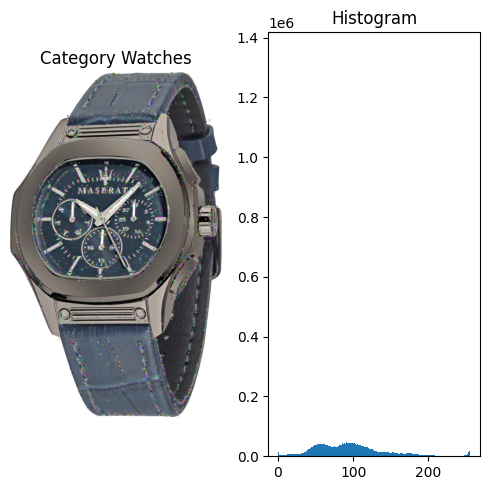

Image: 893aa5ed55f7cff2eccea7758d7a86bd.jpg
Number of keypoints: 4493
Descriptors size: (4493, 128)


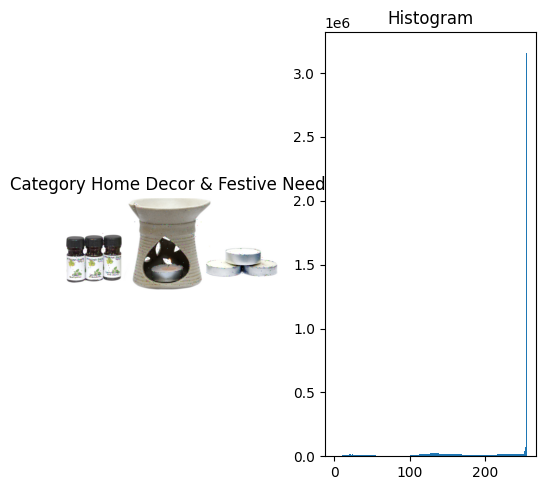

Image: f0938b0d88eac91deee6d5add54097d3.jpg
Number of keypoints: 2104
Descriptors size: (2104, 128)


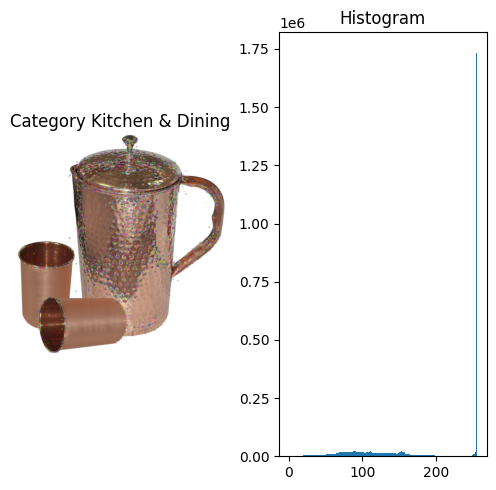

Image: e9420e9483f16db81c64dddf99f34841.jpg
Number of keypoints: 4061
Descriptors size: (4061, 128)


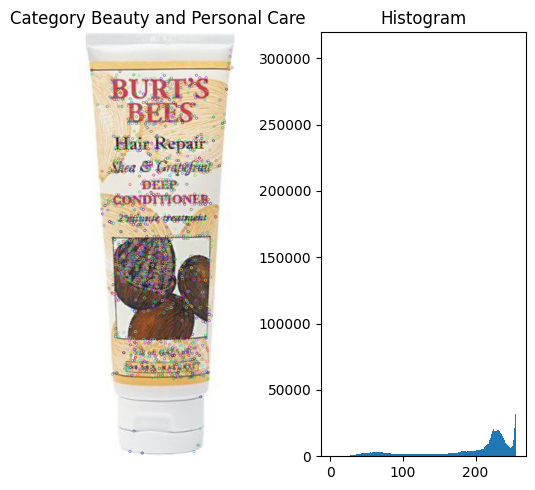

Image: 2d50e4c6ccf8befe9335ac8f97a11712.jpg
Number of keypoints: 2176
Descriptors size: (2176, 128)


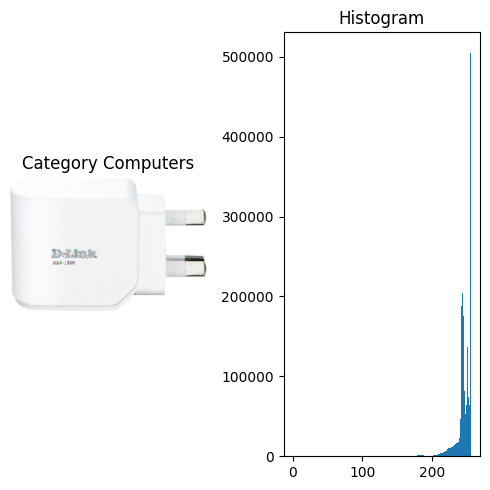

Image: d1899ab1d5c79ddaa311bc9f04d198ed.jpg
Number of keypoints: 202
Descriptors size: (202, 128)


1049it [02:21,  7.40it/s]

Time taken: 141.84s


In [131]:
display_keypoints()
full_resolution_descriptors = get_descriptors()

In [166]:
best_ari, best_pca_vector, best_labels = compare_and_get_best_clusters(full_resolution_descriptors, images_df['category_code'])
# Add row to the results comparison dataframe
new_row = pd.DataFrame[{'Algorithm': 'SIFT', 'Method': 'Full colors resolution', 'ARI': best_ari}]
results_comparison = pd.concat(new_row)

All descriptors shape: (5977631, 128)
Number of clusters to test: 10
Full resolution clusters range: [  70  333  597  861 1125 1388 1652 1916 2180 2444]
Creating 70 descriptors clusters...


100%|██████████| 1049/1049 [00:01<00:00, 724.95it/s]


Visual bag of words dimension: (1049, 70)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 52)
Time taken: 6.19s
Creating 333 descriptors clusters...


100%|██████████| 1049/1049 [00:02<00:00, 399.31it/s]


Visual bag of words dimension: (1049, 333)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 203)
Time taken: 13.91s
Creating 597 descriptors clusters...


100%|██████████| 1049/1049 [00:03<00:00, 315.67it/s]


Visual bag of words dimension: (1049, 597)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 319)
Time taken: 19.78s
Creating 861 descriptors clusters...


100%|██████████| 1049/1049 [00:04<00:00, 242.80it/s]


Visual bag of words dimension: (1049, 861)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 414)
Time taken: 25.68s
Creating 1125 descriptors clusters...


100%|██████████| 1049/1049 [00:05<00:00, 195.52it/s]


Visual bag of words dimension: (1049, 1125)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 484)
Time taken: 30.61s
Creating 1388 descriptors clusters...


100%|██████████| 1049/1049 [00:06<00:00, 168.66it/s]


Visual bag of words dimension: (1049, 1388)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 535)
Time taken: 36.58s
Creating 1652 descriptors clusters...


100%|██████████| 1049/1049 [00:06<00:00, 155.96it/s]


Visual bag of words dimension: (1049, 1652)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 580)
Time taken: 40.57s
Creating 1916 descriptors clusters...


100%|██████████| 1049/1049 [00:07<00:00, 141.20it/s]


Visual bag of words dimension: (1049, 1916)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 602)
Time taken: 44.09s
Creating 2180 descriptors clusters...


100%|██████████| 1049/1049 [00:08<00:00, 128.80it/s]


Visual bag of words dimension: (1049, 2180)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 632)
Time taken: 48.64s
Creating 2444 descriptors clusters...


100%|██████████| 1049/1049 [00:09<00:00, 116.10it/s]


Visual bag of words dimension: (1049, 2444)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 649)
Time taken: 53.45s
scores:
[(52, 0.04831155831578978), (203, 0.04514722971043963), (319, 0.038741023888361925), (414, 0.03391890755260611), (632, 0.026223416981609314), (484, 0.023607943477581154), (535, 0.023154736669436272), (649, 0.019736185191181917), (580, 0.016382328615353478), (602, 0.0016337004550079802)]


TypeError: 'type' object is not subscriptable

In [151]:
best_pca_vector.shape

(1049, 52)

Diplay the T-SNE plot for the best result...
ARI: 0.05, Vector dimension: 52


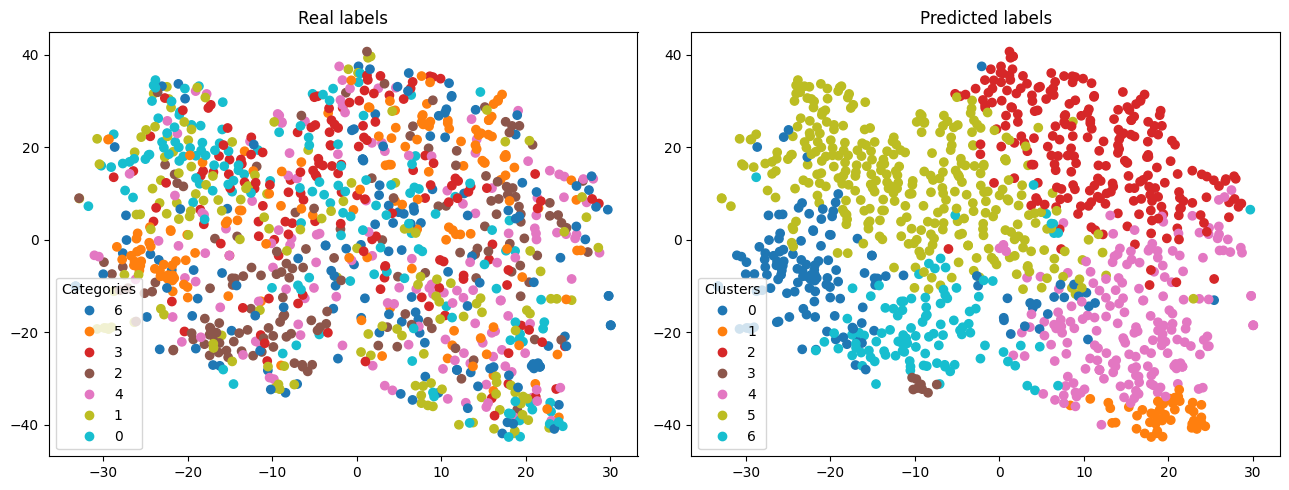

In [157]:
plot_tsne(best_pca_vector=best_pca_vector, best_ari=best_ari, best_labels=best_labels, real_labels=images_df['category_code'])

### Resized image

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_6638/1168618370.py:27: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(image.ravel(), 256, [0, 256])


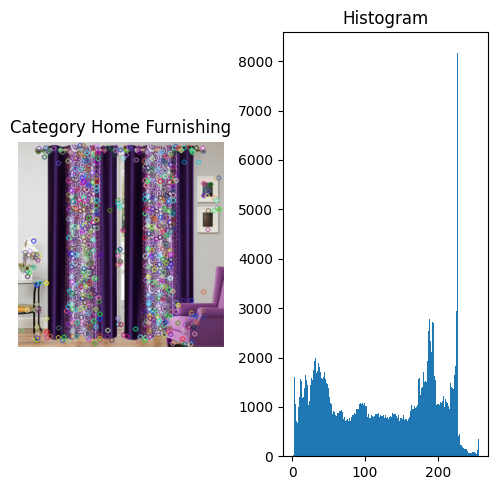

Image: 55b85ea15a1536d46b7190ad6fff8ce7.jpg
Number of keypoints: 694
Descriptors size: (694, 128)


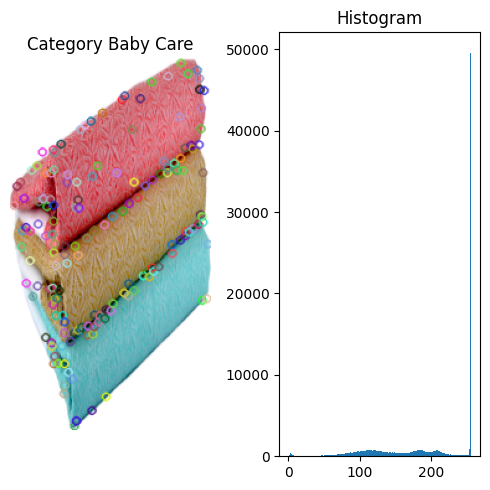

Image: 7b72c92c2f6c40268628ec5f14c6d590.jpg
Number of keypoints: 175
Descriptors size: (175, 128)


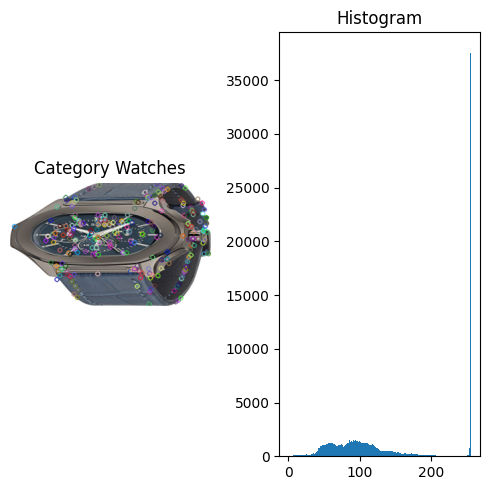

Image: 893aa5ed55f7cff2eccea7758d7a86bd.jpg
Number of keypoints: 289
Descriptors size: (289, 128)


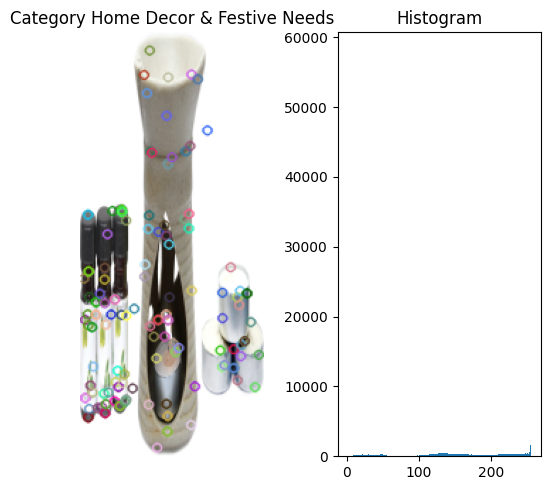

Image: f0938b0d88eac91deee6d5add54097d3.jpg
Number of keypoints: 136
Descriptors size: (136, 128)


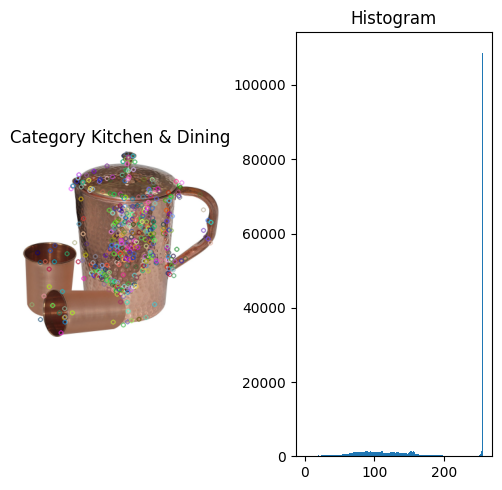

Image: e9420e9483f16db81c64dddf99f34841.jpg
Number of keypoints: 456
Descriptors size: (456, 128)


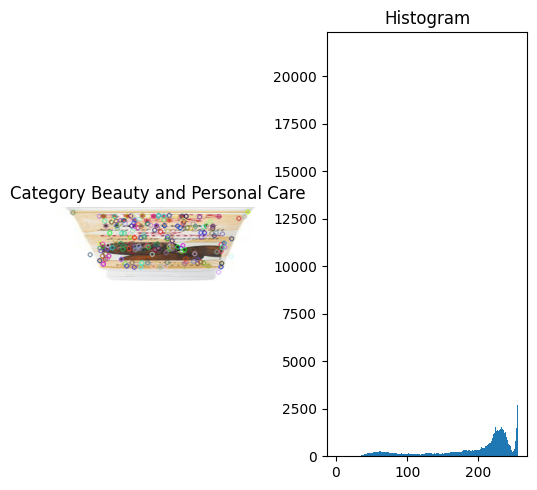

Image: 2d50e4c6ccf8befe9335ac8f97a11712.jpg
Number of keypoints: 224
Descriptors size: (224, 128)


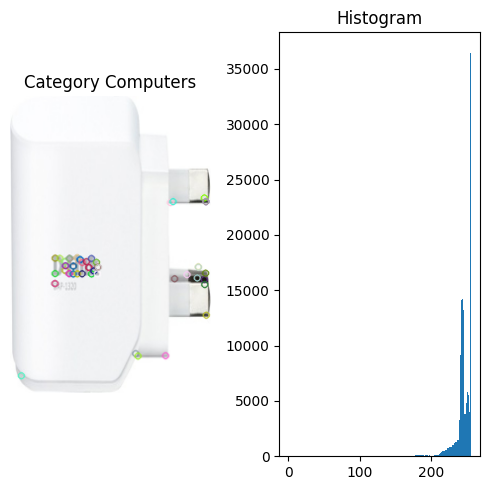

Image: d1899ab1d5c79ddaa311bc9f04d198ed.jpg
Number of keypoints: 55
Descriptors size: (55, 128)


1049it [00:19, 54.24it/s]

Time taken: 19.34s
Number of descriptors: 1049


In [158]:
# Resizing the images
display_keypoints(resize=300)
resized_descriptors = get_descriptors(resize=300)
print(f'Number of descriptors: {len(resized_descriptors)}')

All descriptors shape: (310533, 128)
Number of clusters to test: 10
Full resolution clusters range: [ 70 124 178 232 286 340 394 448 502 557]
Creating 70 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 5526.70it/s]


Visual bag of words dimension: (1049, 70)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 63)
Time taken: 0.85s
Creating 124 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 4581.13it/s]


Visual bag of words dimension: (1049, 124)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 111)
Time taken: 1.14s
Creating 178 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 3876.94it/s]


Visual bag of words dimension: (1049, 178)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 156)
Time taken: 1.68s
Creating 232 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 3467.94it/s]


Visual bag of words dimension: (1049, 232)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 202)
Time taken: 2.27s
Creating 286 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 3028.55it/s]


Visual bag of words dimension: (1049, 286)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 243)
Time taken: 1.67s
Creating 340 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2843.49it/s]


Visual bag of words dimension: (1049, 340)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 284)
Time taken: 1.79s
Creating 394 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2219.30it/s]


Visual bag of words dimension: (1049, 394)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 324)
Time taken: 2.31s
Creating 448 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2342.78it/s]


Visual bag of words dimension: (1049, 448)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 363)
Time taken: 2.34s
Creating 502 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2076.60it/s]


Visual bag of words dimension: (1049, 502)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 398)
Time taken: 2.69s
Creating 557 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 1914.08it/s]


Visual bag of words dimension: (1049, 557)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 433)
Time taken: 2.72s
scores:
[(63, 0.03515083920757546), (111, 0.027514989825953306), (156, 0.02727564200789455), (243, 0.02433061259763127), (202, 0.022179606468889994), (284, 0.016603990006643272), (363, 0.015522673833550802), (324, 0.011203316915548786), (433, 0.010479575772307678), (398, 0.005391123114622733)]
Diplay the T-SNE plot for the best result...
ARI: 0.04, Vector dimension: 63


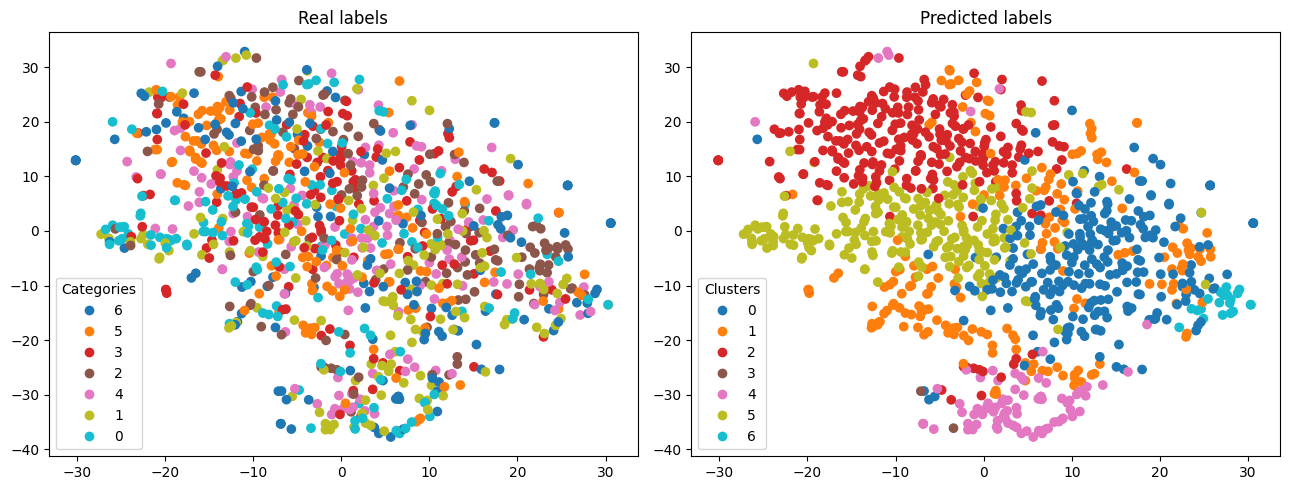

In [ ]:
best_ari, best_pca_vector, best_labels = compare_and_get_best_clusters(resized_descriptors, images_df['category_code'])
# Add row to the results comparison dataframe
results_comparison = pd.concat(pd.DataFrame[{'Algorithm': 'SIFT', 'Method': 'Resized colored images', 'ARI': best_ari}])
plot_tsne(best_pca_vector=best_pca_vector, best_ari=best_ari, best_labels=best_labels, real_labels=images_df['category_code'])

### Greyscale

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_6638/1168618370.py:27: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(image.ravel(), 256, [0, 256])


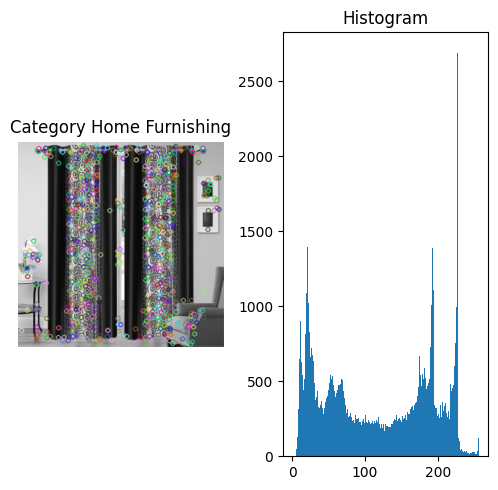

Image: 55b85ea15a1536d46b7190ad6fff8ce7.jpg
Number of keypoints: 694
Descriptors size: (694, 128)


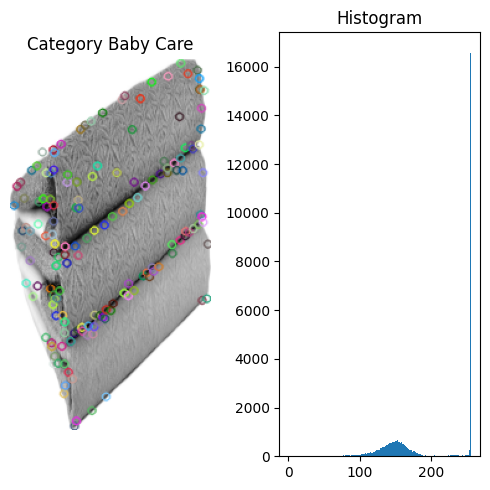

Image: 7b72c92c2f6c40268628ec5f14c6d590.jpg
Number of keypoints: 175
Descriptors size: (175, 128)


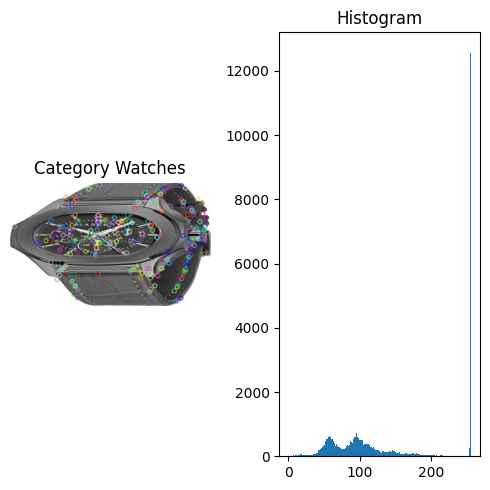

Image: 893aa5ed55f7cff2eccea7758d7a86bd.jpg
Number of keypoints: 289
Descriptors size: (289, 128)


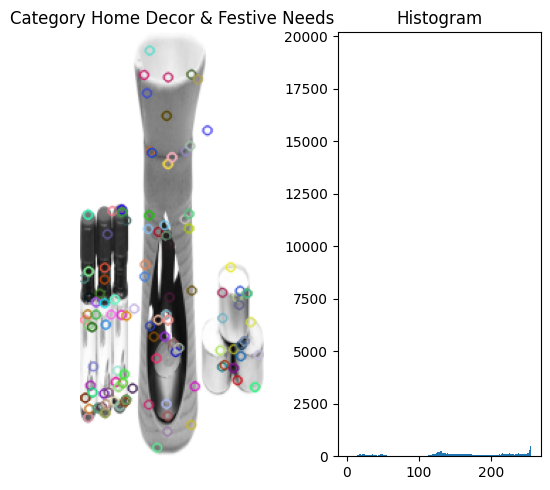

Image: f0938b0d88eac91deee6d5add54097d3.jpg
Number of keypoints: 136
Descriptors size: (136, 128)


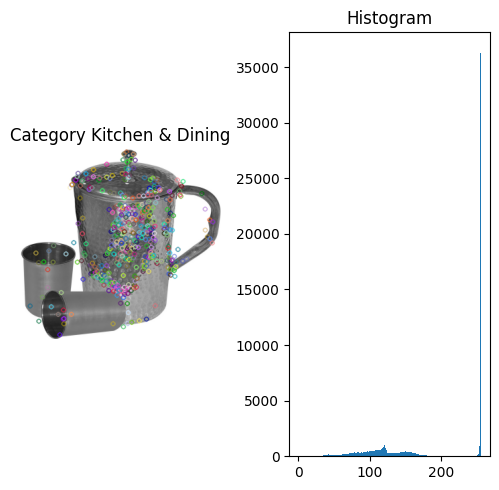

Image: e9420e9483f16db81c64dddf99f34841.jpg
Number of keypoints: 456
Descriptors size: (456, 128)


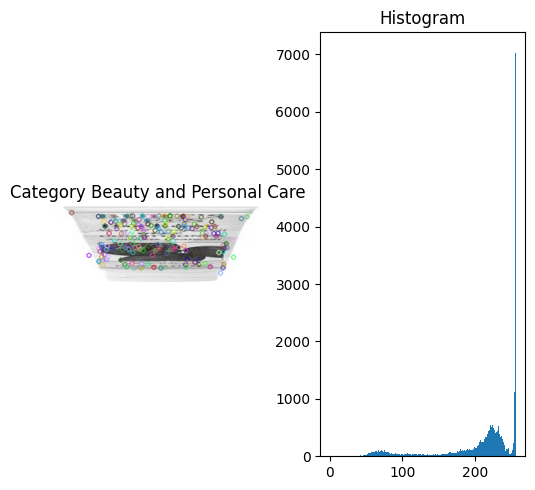

Image: 2d50e4c6ccf8befe9335ac8f97a11712.jpg
Number of keypoints: 224
Descriptors size: (224, 128)


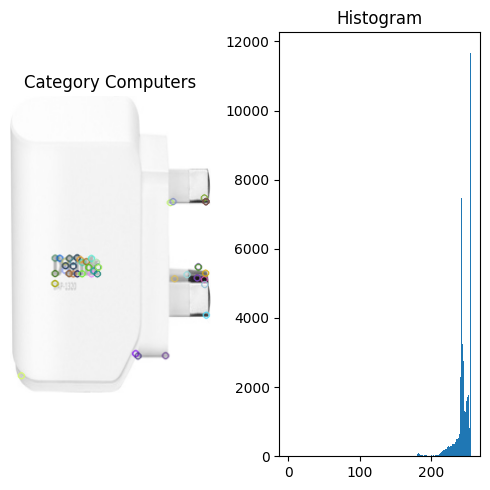

Image: d1899ab1d5c79ddaa311bc9f04d198ed.jpg
Number of keypoints: 55
Descriptors size: (55, 128)


1049it [00:18, 56.02it/s]

Time taken: 18.73s
Number of descriptors: 1049


In [160]:
display_keypoints(greyscale=True, resize=300)
greyscale_descriptors = get_descriptors(resize=300, greyscale=True)
print(f'Number of descriptors: {len(greyscale_descriptors)}')

All descriptors shape: (422719, 128)
Number of clusters to test: 10
Full resolution clusters range: [ 70 134 198 263 327 392 456 521 585 650]
Creating 70 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 4581.51it/s]


Visual bag of words dimension: (1049, 70)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 62)
Time taken: 0.88s
Creating 134 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 3422.37it/s]


Visual bag of words dimension: (1049, 134)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 119)
Time taken: 1.66s
Creating 198 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2874.23it/s]


Visual bag of words dimension: (1049, 198)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 174)
Time taken: 1.73s
Creating 263 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2674.10it/s]


Visual bag of words dimension: (1049, 263)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 229)
Time taken: 1.84s
Creating 327 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2328.45it/s]


Visual bag of words dimension: (1049, 327)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 279)
Time taken: 2.05s
Creating 392 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 2125.13it/s]


Visual bag of words dimension: (1049, 392)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 331)
Time taken: 2.48s
Creating 456 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 1870.61it/s]


Visual bag of words dimension: (1049, 456)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 377)
Time taken: 2.71s
Creating 521 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 1736.14it/s]


Visual bag of words dimension: (1049, 521)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 425)
Time taken: 3.26s
Creating 585 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 1604.68it/s]


Visual bag of words dimension: (1049, 585)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 464)
Time taken: 3.20s
Creating 650 descriptors clusters...


100%|██████████| 1049/1049 [00:00<00:00, 1476.71it/s]


Visual bag of words dimension: (1049, 650)
Starting dimensionality reduction...
Reduced visual bag of words dimension: (1049, 507)
Time taken: 3.30s
scores:
[(279, 0.06034490444946682), (229, 0.05764090819399464), (62, 0.05088271471015787), (464, 0.04634182762530168), (174, 0.04606672284896991), (425, 0.045307082328568095), (377, 0.044771230460564), (119, 0.042674125882522854), (331, 0.038436755282613304), (507, 0.023071899179265887)]
Diplay the T-SNE plot for the best result...
ARI: 0.06, Vector dimension: 279


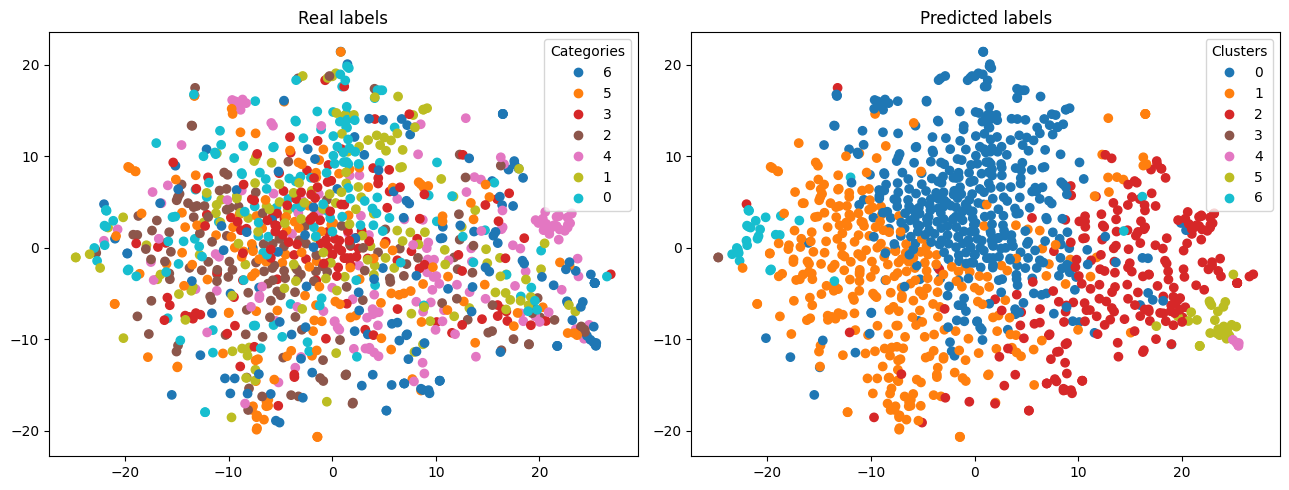

In [ ]:
best_ari, best_pca_vector, best_labels = compare_and_get_best_clusters(greyscale_descriptors, images_df['category_code'])
# Add row to the results comparison dataframe
results_comparison = pd.concat(pd.DataFrame[{'Algorithm': 'SIFT', 'Method': 'Greyscale resized images', 'ARI': best_ari}])
plot_tsne(best_pca_vector=best_pca_vector, best_ari=best_ari, best_labels=best_labels, real_labels=images_df['category_code'])

## CNN

Convolutionnal Neural Networks are used as unsupervised image classification solution. The interest of this deep learning models is that the image features are automatically found.

### VGG-16

Pre-trained CNN composed with :
- 13 convolutional layers
- 3 fully-connected layers

Input = colored image 224 x 224 px
Output = vector of length 1000

![VGG-16 layers](https://user.oc-static.com/upload/2018/03/14/15209905022025_vgg-16-flat.png)

Convolutionnal layer hyperparameters :
- filters size F = 3 x 3
- step S = 1 px
- zero-padding P = 1 px (input volumes size = output size)
- activation function = ReLU

Pooling hyperparameters :
- cell size F = 2x2 px
- S = 2px

#### Setup

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [35]:
# Instantiate the pretrained model without the last layers
# with the parameter include_top=False and precise the input shape
model = VGG16(include_top=False, input_shape=(224, 224, 3), pooling='avg', classes=len(classes))
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def preprocess_image(image: str, path: str=path, target_size: tuple =(224, 224)) -> np.array:
    """Preprocess an image for the model.

    Args:
        image (str): image.
        path (str, optional): path. Defaults to path.
        target_size (tuple, optional): target_size. Defaults to (224, 224).

    Returns:
        np.array: Preprocessed image
    """
    # load the image
    image = load_img(path + image, target_size=target_size)
    # convert the image to an array
    image_array = img_to_array(image)
    # reshape the image
    image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

    return image_array

In [20]:
# Train only the classifier
for layer in model.layers:
    layer.trainable = False

A VGG16 takes as input images 224 x 224 in color (channel = 3), we have to pre process the images before sending them to the CNN.

In [36]:
# Extract images features
embeddings = []
for row in images_df.itertuples():
    image_features = preprocess_image(row.image)
    features = model.predict(image_features)
    embeddings.append(features.flatten())

# Convert the embeddings to a numpy array
embeddings = np.array(embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

/Users/ikusawalaetitia/Desktop/Desktop - Ikusawa’s Mac mini/work/projects/python/P6-txt-img_classification/p6env/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

In [37]:
pca = PCA(n_components=0.99, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

In [38]:
kmeans = KMeans(n_clusters=len(classes), random_state=42)
kmeans.fit(reduced_embeddings)

# Get ari score
ari = adjusted_rand_score(images_df['category_code'], kmeans.labels_)
print(f'ARI: {ari:.2f}')

ARI: 0.35


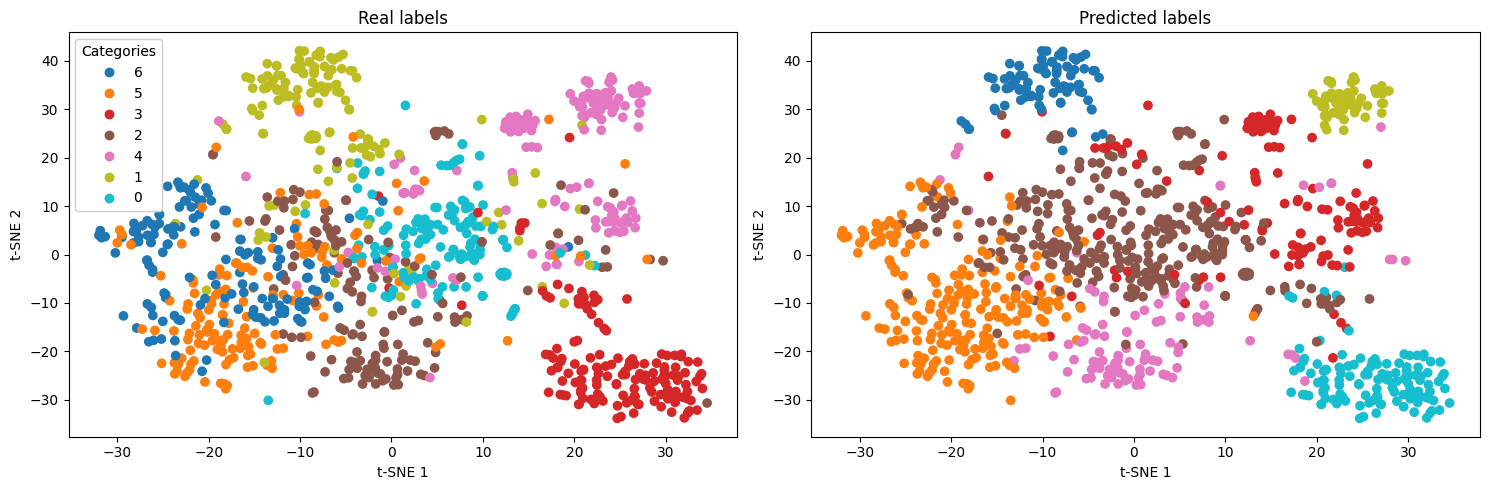

In [39]:
tsne = manifold.TSNE(n_components=2, perplexity=30, init='random', random_state=42)
X_tsne = tsne.fit_transform(reduced_embeddings)

true_labels, unique_labels = pd.factorize(images_df['category_code'])

categories_names = list(unique_labels)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Real categories
scatter = axes[0].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=true_labels, cmap='tab10')
axes[0].set_title('Real labels')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

if len(categories_names) == len(np.unique(true_labels)):
    legend1 = axes[0].legend(
        handles=scatter.legend_elements()[0],
        labels=categories_names,
        title='Categories'
    )
    axes[0].add_artist(legend1)
else:
    print(f'Error on labels number: {len(categories_names)}')

# Predicted categories
scatter = axes[1].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=kmeans.labels_, cmap='tab10')
axes[1].set_title('Predicted labels')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

plt.tight_layout()

plt.show()